# Churn Prediction with Text and Interpretability

This notebook runs the entire churn prediction pipeline from data preparation to model evaluation and interpretation.

### Setup

In [1]:
import os
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
from pathlib import Path
import yaml
from IPython.display import HTML

os.chdir("../scripts")

import preprocess
import train

In [2]:
with open("../model/params.yaml", "r") as params_file:
    params = yaml.safe_load(params_file)

model_dir = params['model_dir']
data_dir = params['data_dir']

In [3]:
os.environ['PYTHONIOENCODING'] = 'utf-8'

%load_ext autoreload
%autoreload 2

### Load and Prepare the Data

In [4]:
import csv
from preprocess import create_joint_dataset

df_categorical = pd.read_csv(Path(data_dir, "train.csv"))
df_text = pd.read_excel(Path(data_dir, "text.xlsx"))
df_text.to_csv(Path(data_dir, 'df_text.csv'), 
               index=False, 
               encoding='utf-8-sig', 
               quoting=csv.QUOTE_NONNUMERIC)
print(f"Input shapes:")
print(f"  df_categorical: {df_categorical.shape}")
print(f"  df_text: {df_text.shape}")
print(f"  df_text churn: {df_text['churn'].value_counts().to_dict()}")

df = create_joint_dataset(df_categorical, df_text)
print(f"\nOutput:")
print(f"  df shape: {df.shape}")
print(f"  df churn: {df['churn'].value_counts().to_dict()}")

df.to_csv(Path(data_dir, "churn_dataset.csv"), index=False)

Input shapes:
  df_categorical: (3941, 11)
  df_text: (1184, 2)
  df_text churn: {1: 603, 0: 581}

Output:
  df shape: (1184, 12)
  df churn: {1: 603, 0: 581}


In [5]:
from preprocess import run_preprocessing

run_preprocessing(use_existing=True)

 Saved to ..\data


In [6]:
df = pd.read_csv("../data/churn_dataset.csv")
df.head(5)

,churn,chat_log,Tenure,WarehouseToHome,NumberOfDeviceRegistered,PreferedOrderCat,SatisfactionScore,MaritalStatus,NumberOfAddress,Complain,DaySinceLastOrder,CashbackAmount
0,0,Customer: I need to know if this specific bran...,27.0,9.0,5,Grocery,1,Married,4,0,8.0,279.27
1,1,Customer: I was charged an annual fee for a se...,14.0,10.0,5,Mobile Phone,3,Married,3,1,3.0,151.83
2,1,Customer: I received a notification that my or...,20.0,NaN,3,Mobile,3,Single,5,0,0.0,124.79
3,0,"Customer: I'm married, and I'm looking to upda...",8.0,NaN,3,Mobile,3,Married,2,0,0.0,124.04
4,1,Customer: I tried to use the 'Price Match' too...,1.0,29.0,4,Mobile Phone,3,Married,6,1,2.0,146.32


### Train and Evaluate the Model

In [8]:
data_dir = Path("../data")

train_df_full = pd.read_csv(data_dir / "train2.csv")
test_df_full = pd.read_csv(data_dir / "test2.csv")

TESTING_MODE = True
N_SAMPLES = 100

if TESTING_MODE:
    print(f"TESTING MODE: Using only first {N_SAMPLES} samples")
    train_df = train_df_full.head(N_SAMPLES)
    test_df = test_df_full.head(25)
    print(f"Original: {len(train_df_full)} train, {len(test_df_full)} test")
else:
    train_df = train_df_full
    test_df = test_df_full

print(f"Using: {len(train_df)} train, {len(test_df)} test")
print(f"Churn rate (train): {train_df['churn'].mean():.2%}")
print(f"Churn rate (test): {test_df['churn'].mean():.2%}")

TESTING MODE: Using only first 100 samples
Original: 947 train, 237 test
Using: 100 train, 25 test
Churn rate (train): 60.00%
Churn rate (test): 44.00%


In [9]:
numerical_cols = train_df.select_dtypes(include=[np.number]).columns.tolist()
numerical_cols = [c for c in numerical_cols if c != 'churn']

categorical_cols = train_df.select_dtypes(include=['object']).columns.tolist()
categorical_cols = [c for c in categorical_cols if c != 'chat_log']

print(f"Numerical: {len(numerical_cols)}, Categorical: {len(categorical_cols)}")

X_train = train_df[numerical_cols + categorical_cols]
y_train = train_df['churn'].values
text_train = train_df['chat_log'].values

X_test = test_df[numerical_cols + categorical_cols]
y_test = test_df['churn'].values
text_test = test_df['chat_log'].values

print(f"X_train shape: {X_train.shape}")
print(f"Text samples: {len(text_train)}")

Numerical: 8, Categorical: 2
X_train shape: (100, 10)
Text samples: 100


In [10]:
# from ablation_study import (
#     run_ablation_study,
#     quick_leakage_test,
#     train_tabular_only,
#     train_text_only
# )

In [11]:
# Ablation study (optional analyse):
# ablation_results = run_ablation_study(train_df, test_df)

# tabular_auc = ablation_results['tabular']['test_auc']
# text_auc = ablation_results['text']['test_auc']

# if text_auc > 0.95:
#     print("\n[CONCLUSION] Text is the primary source of leakage.")
#     print("The text data appears to be generated with label-aware patterns.")
# elif text_auc > tabular_auc + 0.1:
#     print("\n[CONCLUSION] Text adds genuine predictive value.")
# else:
#     print("\n[CONCLUSION] Text provides minimal additional value over tabular features.")

In [12]:
import train
combined_model, xgb_model, test_loader = train.train_model(
    X_train=X_train,
    y_train=y_train,
    X_test=X_test,
    y_test=y_test,
    text_train=text_train,
    text_test=text_test
)

Epoch 1: Loss=3.1971, TrainAUC=0.6650, TestAUC=0.4935
Epoch 2: Loss=1.6400, TrainAUC=0.9983, TestAUC=0.9286
Epoch 3: Loss=1.3679, TrainAUC=1.0000, TestAUC=0.9545
Epoch 4: Loss=0.9928, TrainAUC=1.0000, TestAUC=0.9870
Epoch 5: Loss=0.6133, TrainAUC=1.0000, TestAUC=1.0000


In [15]:
import torch
import joblib
from transformers import DistilBertTokenizer

from train import DistilBertTextClassifier, TabularModel, CombinedModel, predict, predict_with_xgboost

pred1 = predict(X_test, text_test)
pred2 = predict_with_xgboost(X_test)

print("Combined model prob:", pred1[0])
print("XGBoost prob:", pred2[0])

Combined model prob: 0.5832666
XGBoost prob: 0.98317355


In [16]:
from train import plot_roc_curve, plot_pr_curve
plot_roc_curve(X_test, text_test, y_test)
plot_pr_curve(X_test, text_test, y_test)
    
print("Evaluation plots saved to:", model_dir)

Evaluation plots saved to: ../model


### Interpret the Model

#### Categorical and Numerical Features

In [17]:
import sys
import webbrowser
from IPython.display import display, HTML, Image
import interpret

In [18]:
xgb_model = joblib.load("../model/xgboost_model.joblib")
feature_cols = xgb_model.get_booster().feature_names

XGBoost model interpretation

Analyzing 237 samples with 10 features...

Computing feature importance...
Top 10 important features:
                    feature  importance
0                    Tenure    0.252145
9             MaritalStatus    0.207437
5                  Complain    0.202743
4           NumberOfAddress    0.082587
7            CashbackAmount    0.051717
8          PreferedOrderCat    0.050681
6         DaySinceLastOrder    0.047499
2  NumberOfDeviceRegistered    0.042359
3         SatisfactionScore    0.032120
1           WarehouseToHome    0.030711
Feature importance plot saved

Computing SHAP values...
SHAP summary plot saved


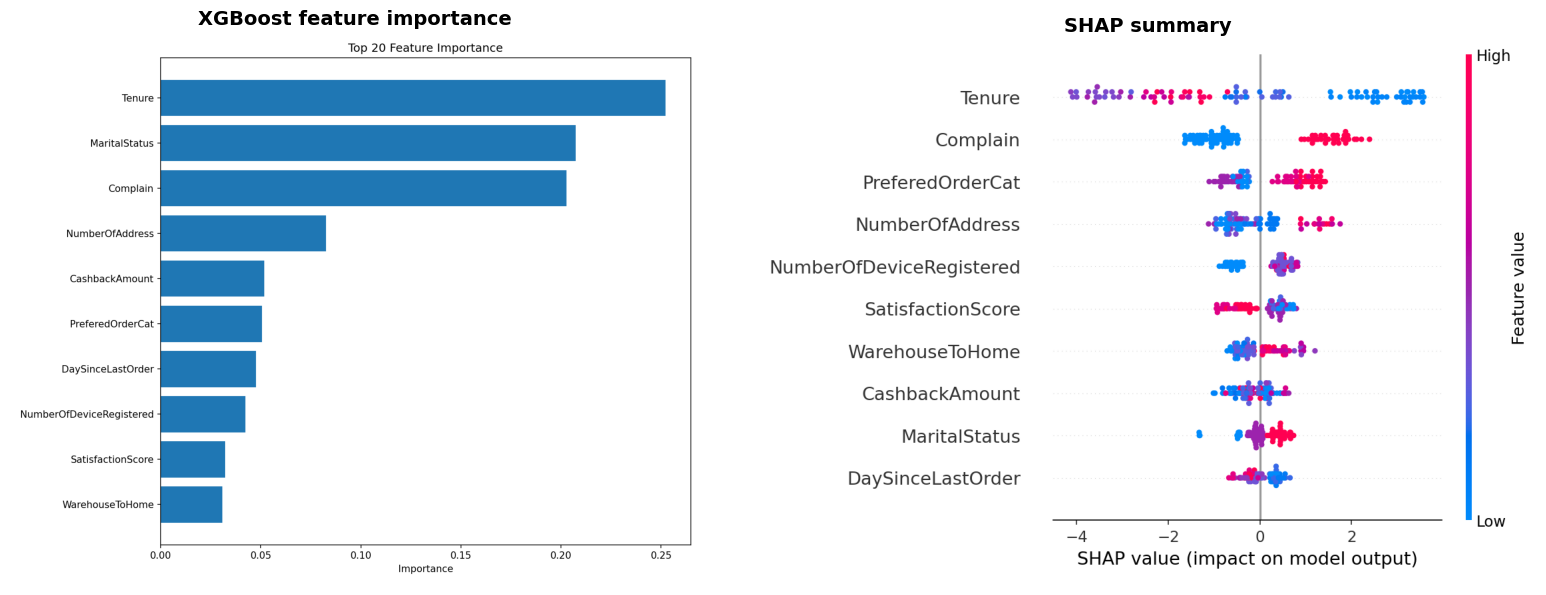

In [19]:
feature_importance, shap_values = interpret.interpret_tabular_model()

fig, axes = plt.subplots(1, 2, figsize=(16, 6))

img1 = plt.imread('../model/xgb_feature_importance.png')
axes[0].imshow(img1)
axes[0].axis('off')
axes[0].set_title('XGBoost feature importance', fontsize=14, fontweight='bold')

img2 = plt.imread('../model/shap_summary.png')
axes[1].imshow(img2)
axes[1].axis('off')
axes[1].set_title('SHAP summary', fontsize=14, fontweight='bold')

plt.tight_layout()
plt.show()

#### Textual Features (focus on customer chats that result in churn)

In [20]:
output_dir, attention_results, gradient_results = interpret.explain_text_with_attention(
    max_samples=5
)

TEXT INTERPRETATION


DistilBertSdpaAttention is used but `torch.nn.functional.scaled_dot_product_attention` does not support `output_attentions=True` or `head_mask`. Falling back to the manual attention implementation, but specifying the manual implementation will be required from Transformers version v5.0.0 onwards. This warning can be removed using the argument `attn_implementation="eager"` when loading the model.


Processing 5 samples...

Sample 1/5

Sample 2/5

Sample 3/5

Sample 4/5

Sample 5/5
Explanations saved to: ..\model\text_explanations
Results saved to: ..\model\text_explanations\interpretation_results.pkl


##### Create joint metric (semantic similarity + marginal contribution + count)

In [21]:
from collections import defaultdict
import interpret
from interpret import (
    get_important_keywords,
    obtain_context,
    analyze_keyword_cooccurrence,
    visualize_keyword_importance,
    create_keyword_summary_report
)

##### Context of keywords

In [22]:
test_df = pd.read_csv("../data/test2.csv")
chats = test_df['chat_log'].dropna().tolist()

results_df = interpret.get_important_keywords(
    attention_results=attention_results,
    gradient_results=gradient_results,
    chats_list=chats,
    top_k=30,
    min_count=2
)

print("\nTop 20 Keywords with Sentiment:")
display(results_df.head(20))


Top 20 Keywords with Sentiment:


,keyword,frequency,avg_attention,avg_gradient,combined_score,sentiment_score,sentiment_label,positive_contexts,negative_contexts,rank
2,feature,2,0.008238,0.000272,0.005052,0.444444,positive,4,0,1
4,apologize,2,0.006798,0.000037,0.004094,-1.000000,negative,0,10,2
6,simple,2,0.005680,0.000337,0.003543,-0.750000,negative,0,3,3
5,authorization,2,0.005736,0.000081,0.003474,-0.500000,negative,0,1,4
1,right,2,0.003448,0.000047,0.002088,-0.444444,negative,2,6,5
3,current,2,0.002734,0.000051,0.001661,0.000000,neutral,2,2,6
0,new,2,0.002559,0.000242,0.001632,0.200000,positive,3,1,7


In [23]:
contexts_dict = {}
for kw in results_df.head(10)['keyword']:
    contexts_dict[kw] = obtain_context(
        chats_list=df['chat_log'],
        keyword=kw,
        max_examples=3,
        highlight=False
    )

CONTEXT ANALYSIS: 'feature'

Found 3 occurrences
Showing 3 examples:

[Example 1] Chat ID: 50, Position: 226
  ...oes it have good shoulder padding?
Agent: Yes, it feature s ergonomic, high-density foam straps.
Customer: S...

[Example 2] Chat ID: 55, Position: 265
  ...tching for night walks.
Customer: Very thoughtful feature ....

[Example 3] Chat ID: 71, Position: 234
  ...e handle comfortable for long use?
Agent: Yes, it feature s a contoured, Pakkawood handle designed for balan...

CONTEXT ANALYSIS: 'apologize'

Found 3 occurrences
Showing 3 examples:

[Example 1] Chat ID: 1, Position: 126
  ...ast year. I have the confirmation email.
Agent: I apologize . It seems the auto-renew flag was not correctly d...

[Example 2] Chat ID: 2, Position: 149
  ....
Agent: Our inventory sync failed temporarily. I apologize for the error.
Customer: So you took my money for...

[Example 3] Chat ID: 4, Position: 108
  ...t it gives me a server error every time.
Agent: I apologize for the broken too

Saved to ../model/keyword_sentiment.png


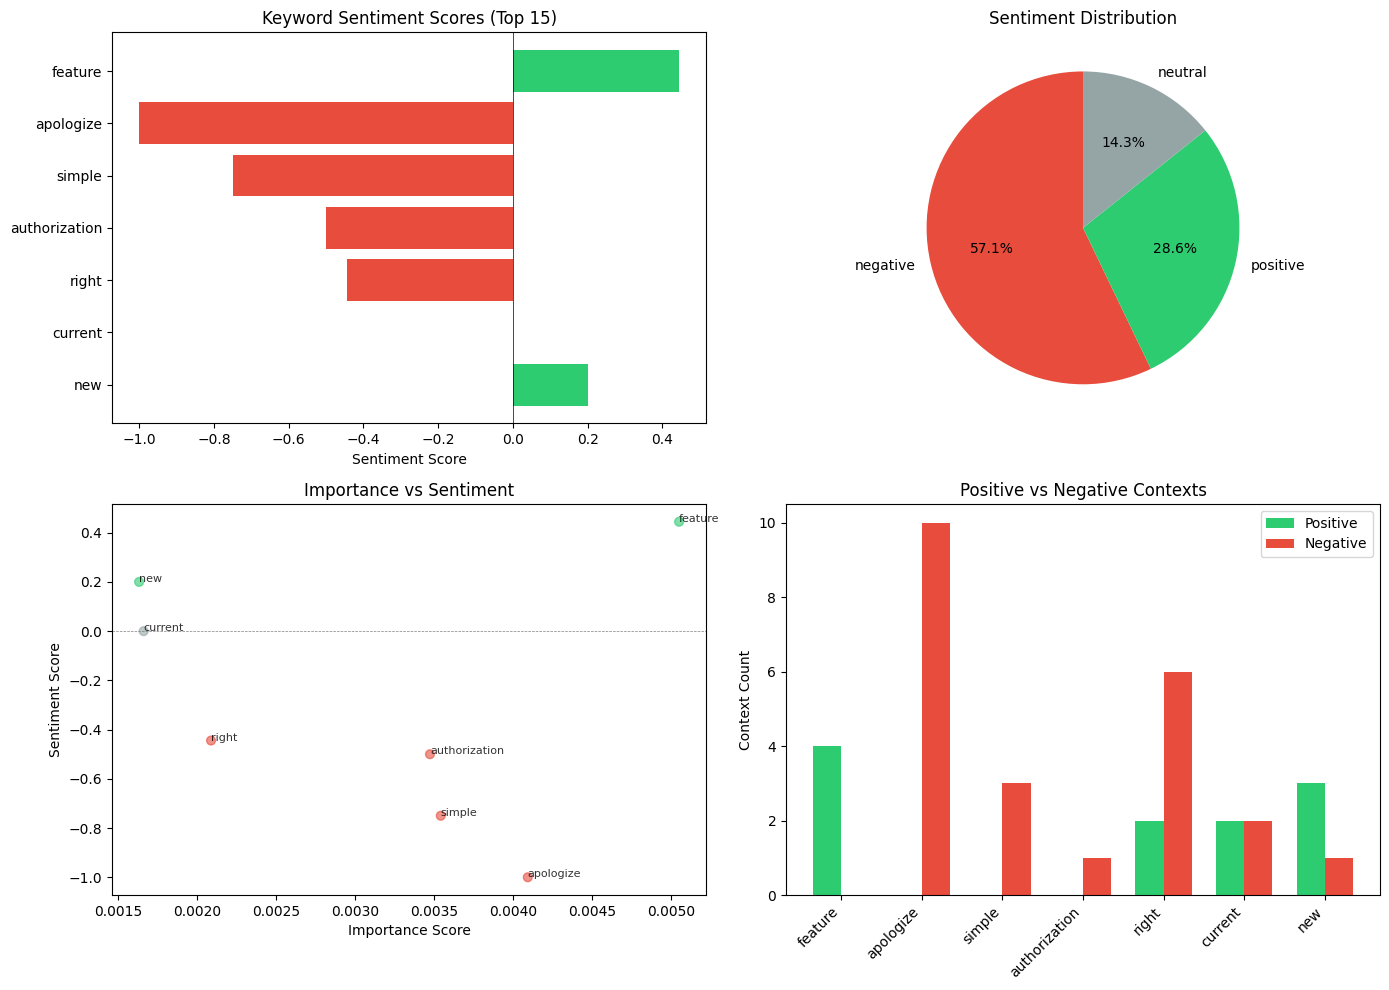

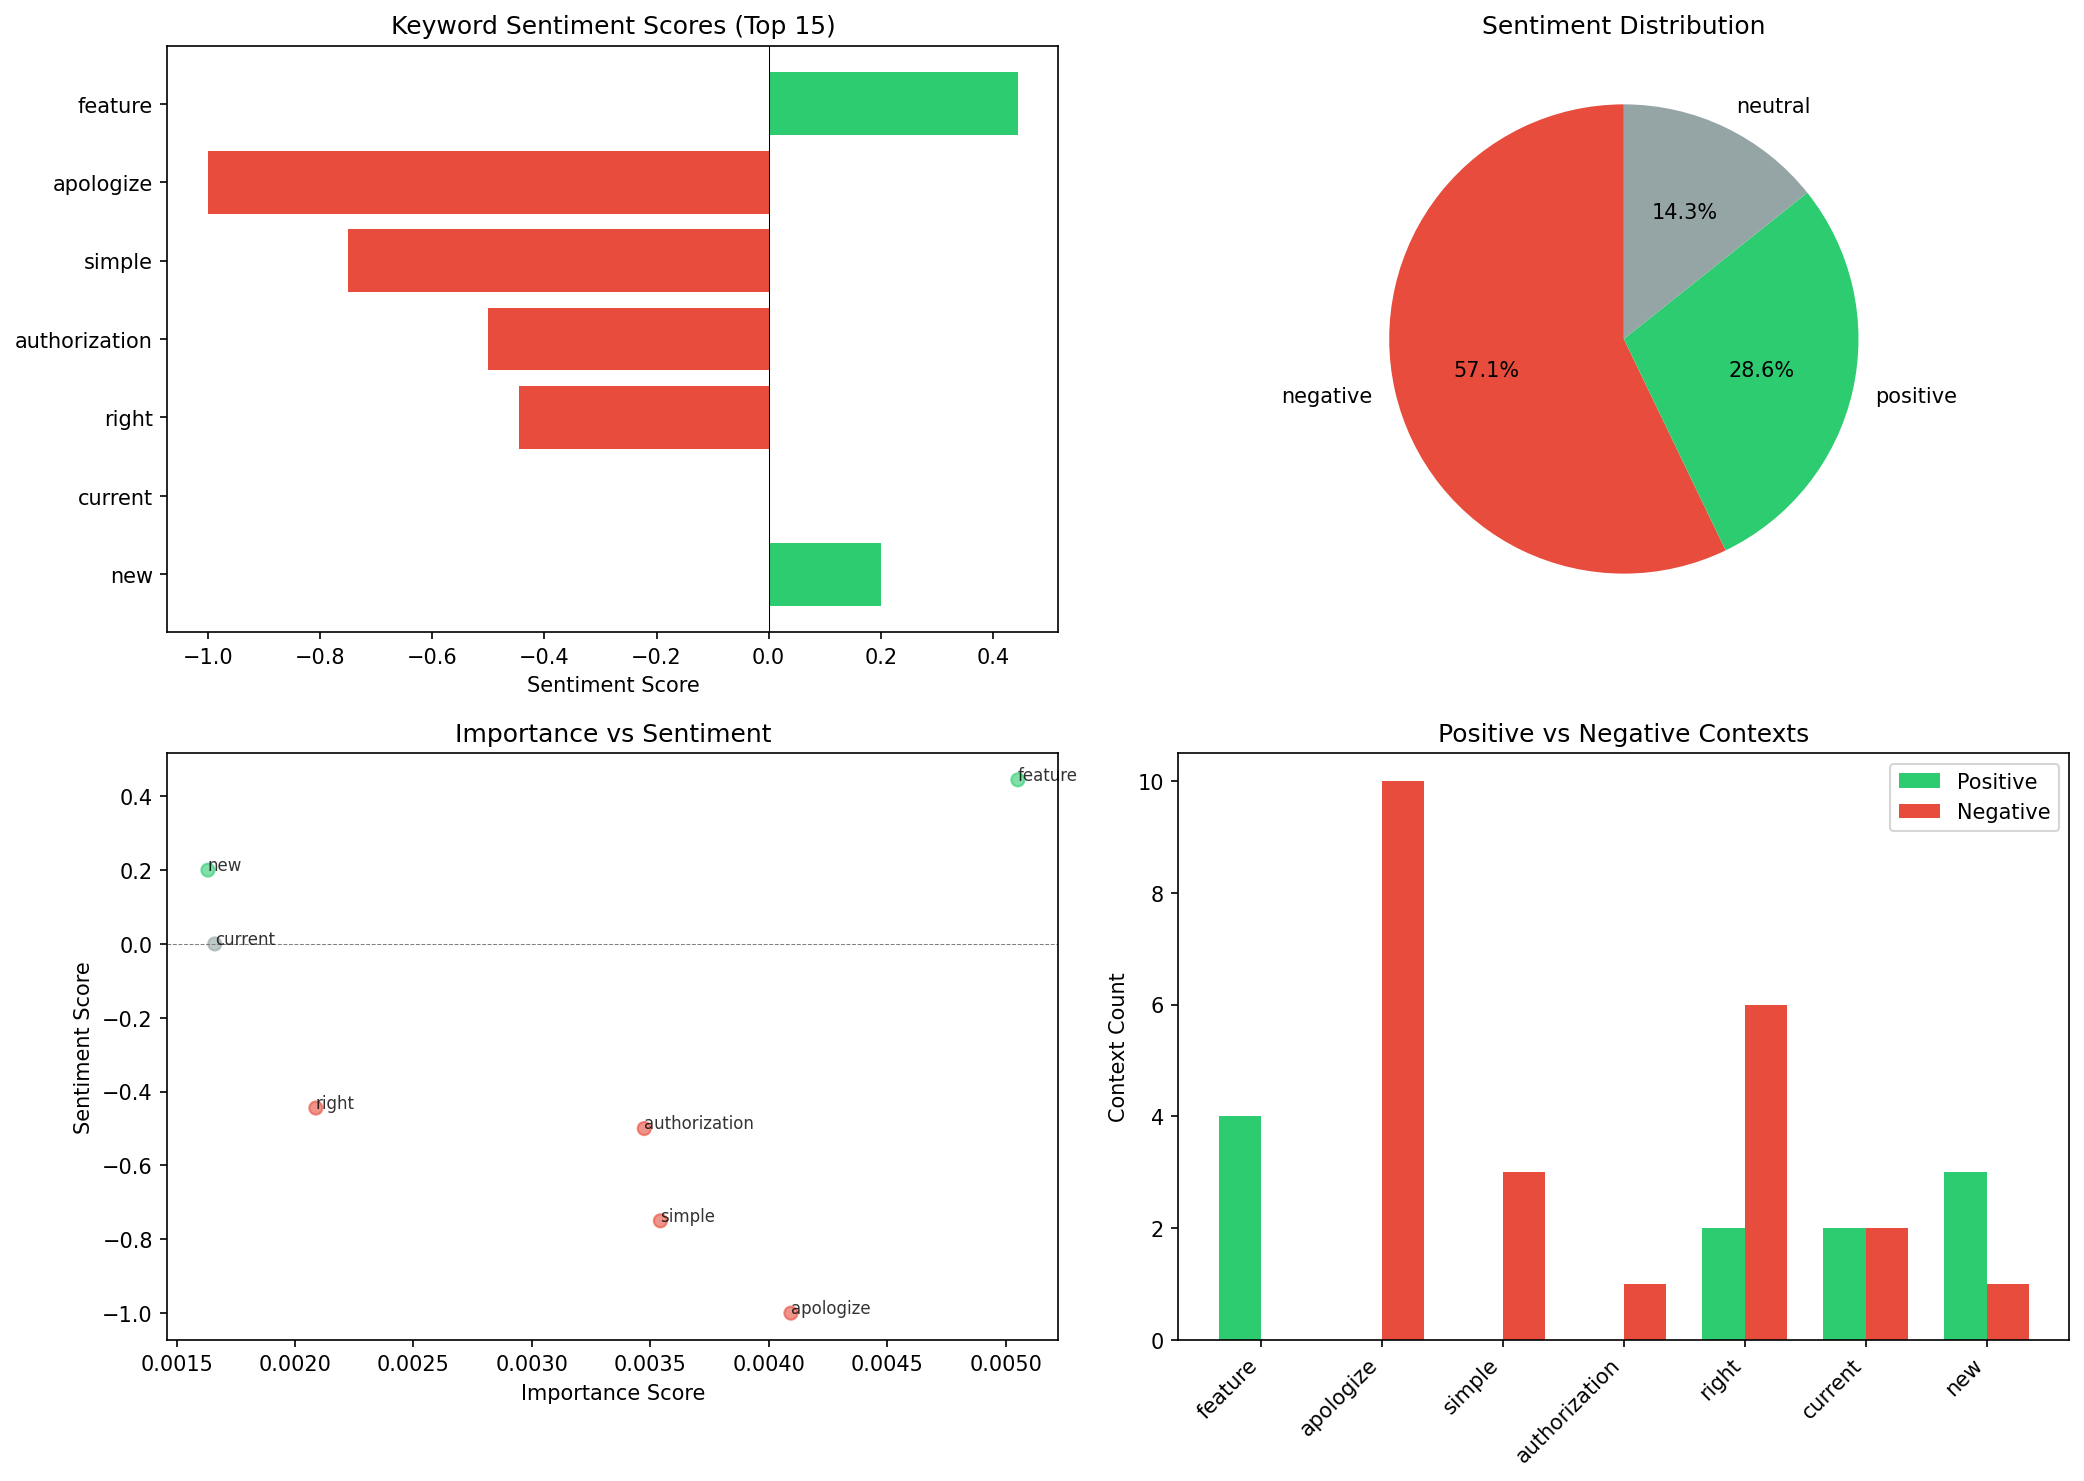

In [24]:
interpret.visualize_keyword_importance(
    results_df=results_df,
    save_path="../model/keyword_sentiment.png"
)
Image(filename=str("../model/keyword_sentiment.png"))

In [25]:
if len(results_df) > 0:
    top_keyword = results_df.iloc[0]['keyword']
    print(f"Analyzing context for top keyword: '{top_keyword}'")
    
    # Use obtain_context for detailed analysis
    contexts = interpret.obtain_context(
        chats_list=chats,
        keyword=top_keyword,
        max_examples=10
    )
    
    # Show sentiment for this keyword
    sentiment_info = results_df[results_df['keyword'] == top_keyword].iloc[0]
    print(f"\nSentiment Analysis:")
    print(f"  Score: {sentiment_info['sentiment_score']:.3f}")
    print(f"  Label: {sentiment_info['sentiment_label']}")
    print(f"  Positive contexts: {sentiment_info['positive_contexts']}")
    print(f"  Negative contexts: {sentiment_info['negative_contexts']}")

Analyzing context for top keyword: 'feature'
CONTEXT ANALYSIS: 'feature'

Found 10 occurrences
Showing 10 examples:

[Example 1] Chat ID: 0, Position: 122
  ...Score is 5. Are there any new independent authors feature d right now?
Agent: A score of 5 is fantastic! We...

[Example 2] Chat ID: 0, Position: 179
  ...d right now?
Agent: A score of 5 is fantastic! We feature a special 'Indie Spotlight' section weekly. Let m...

[Example 3] Chat ID: 4, Position: 315
  ...der's address unchanged.
Customer: That's a great feature . Update the default to [New Address].
Agent: Upda...

[Example 4] Chat ID: 8, Position: 85
  ...ce have built-in surge protection?
Agent: Yes, it feature s integrated circuitry designed to protect against...

[Example 5] Chat ID: 23, Position: 66
  ...to know if this coffee maker has an auto-shutoff feature for safety.
Agent: Yes, it automatically shuts of...

[Example 6] Chat ID: 23, Position: 188
  ...of inactivity.
Customer: That's a crucial safety feature for me.

In [26]:
contexts_dict = {}
for keyword in results_df['keyword'].head(10):
    keyword_contexts = []
    for i, chat in enumerate(chats[:100]):
        if not isinstance(chat, str):
            continue
        import re
        pattern = re.compile(re.escape(keyword), re.IGNORECASE)
        for match in pattern.finditer(chat):
            start = max(0, match.start() - 50)
            end = min(len(chat), match.end() + 50)
            keyword_contexts.append({
                'before': chat[start:match.start()],
                'keyword': match.group(),
                'after': chat[match.end():end],
                'chat_id': i
            })
            if len(keyword_contexts) >= 5:
                break
        if len(keyword_contexts) >= 5:
            break
    contexts_dict[keyword] = keyword_contexts

In [27]:
interpret.create_keyword_summary_report(
    results_df=results_df,
    contexts_dict=contexts_dict,
    output_path="../model/keyword_report.html",
    top_n=20
)
print("Report generated: keyword_report.html")

GENERATING KEYWORD SUMMARY REPORT
Report saved to: ../model/keyword_report.html
Report generated: keyword_report.html
